In [18]:
from imports import *

### **1- and 2-Layer Quantum Galton Board**

The 1-level Quantum Galton Board (QGB) circuit uses 4 qubits and 2 classical bits.  
- **Qubit 0** is the coin qubit and is placed in an equal superposition using a Hadamard gate $H$, giving a 50% chance of moving left or right.  
- **Qubit 2** is initialized with an $X$ gate to represent the ball's starting position (at each level, the ball can be initialized using the middlemost qubit of the circuit).  
- The first **CSWAP** gate swaps the ball between qubits 1 and 2 depending on the state of the coin qubit.  
- A **CX** gate introduces quantum interference between possible paths.  
- The second **CSWAP** spreads the ball further, allowing it to reach qubit 3.  
- Finally, **qubits 1 and 3** are measured to determine the final position after one level.  

This circuit represents one “peg” of the QGB; higher levels are built by chaining more such coin-and-swap operations.


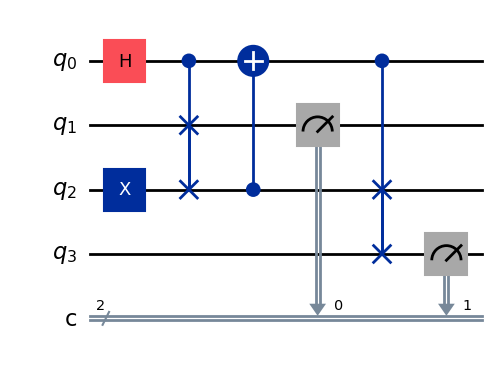

In [19]:
qc = QuantumCircuit(4,2)
qc.h(0)
qc.x(2) # Initialize ball
qc.cswap(0,1,2)
qc.cx(2,0)
qc.cswap(0,2,3)
qc.measure([1,3],[0,1])
qc.draw('mpl')

Similarly, for 2-level:

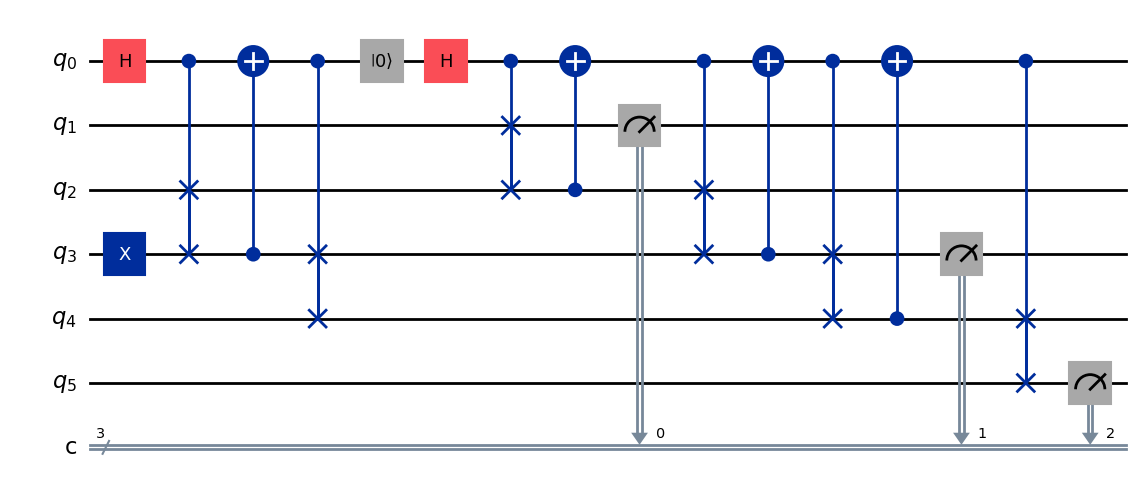

In [20]:
qc = QuantumCircuit(6,3)
qc.h(0)
qc.x(3)
qc.cswap(0,2,3)
qc.cx(3,0)
qc.cswap(0,3,4)
# Reset and put qubit 0 into superposition, again
qc.reset(0)
qc.h(0)
qc.cswap(0,1,2)
qc.cx(2,0)
qc.cswap(0,2,3)
# Extra Controlled-NOT
qc.cx(3,0)
# Extra Controlled-NOT
qc.cswap(0,3,4)
qc.cx(4,0)
qc.cswap(0,4,5)
qc.measure([1,3,5], [0,1,2])
qc.draw('mpl')

In a **2-level Quantum Galton Board (QGB)**, the first level works like the simple 1-level circuit — the coin qubit is put into superposition, and `CSWAP` gates move the ball left or right.  
However, after the first step, **multiple quantum paths can now lead to the same position** in the second step.  
To preserve quantum interference, we must make sure that the coin qubit is correctly entangled with the ball's new position before making the next move.

This is where the **extra controlled-NOT (CX)** gate comes in.  
After the first `CSWAP` in the second level, the CX re-entangles the coin qubit with the ball's updated position, allowing amplitudes from different paths to interfere coherently when they reach the same spot.  
If we skip this step, the paths evolve independently, and the final distribution becomes classical.

This logic extends naturally to **n-level QGBs**:  
in every level after the first, the extra CX ensures the coin correctly "tracks" the ball position, enabling interference between converging paths at all later steps. Lets generalize this and write a function which will work for any level.

In [21]:
def create_qgb_circuit(levels):
    assert levels >= 1, "Levels must be >= 1"

    total_qubits = 2 * levels + 2
    middle = levels + 1

    qreg = QuantumRegister(total_qubits, name="q")
    creg = ClassicalRegister(levels + 1, name="c")
    qc = QuantumCircuit(qreg, creg)

    # Initial superposition and ball placement
    qc.h(0)
    qc.x(middle)

    ball_positions = [middle]

    for step in range(levels):
        qc.reset(0)
        qc.h(0)

        new_positions = set()
        positions_this_step = sorted(ball_positions)

        for i, pos in enumerate(positions_this_step):
            left = pos - 1
            right = pos + 1

            if left >= 1 and right < total_qubits:
                qc.cswap(0, left, pos)
                qc.cx(pos, 0)
                qc.cswap(0, pos, right)

                # Only apply extra CX if this is NOT the last position of this step
                if step >= 1 and i < len(positions_this_step) - 1:
                    qc.cx(right, 0)

                new_positions.update([left, right])

        ball_positions = sorted(new_positions)

    # Measure only the odd-indexed qubits (like [1, 3, 5, 7, 9] for level 4)
    measure_qubits = [i for i in range(1, total_qubits, 2)]
    for i, q in enumerate(measure_qubits[:levels + 1]):
        qc.measure(q, creg[i])

    return qc

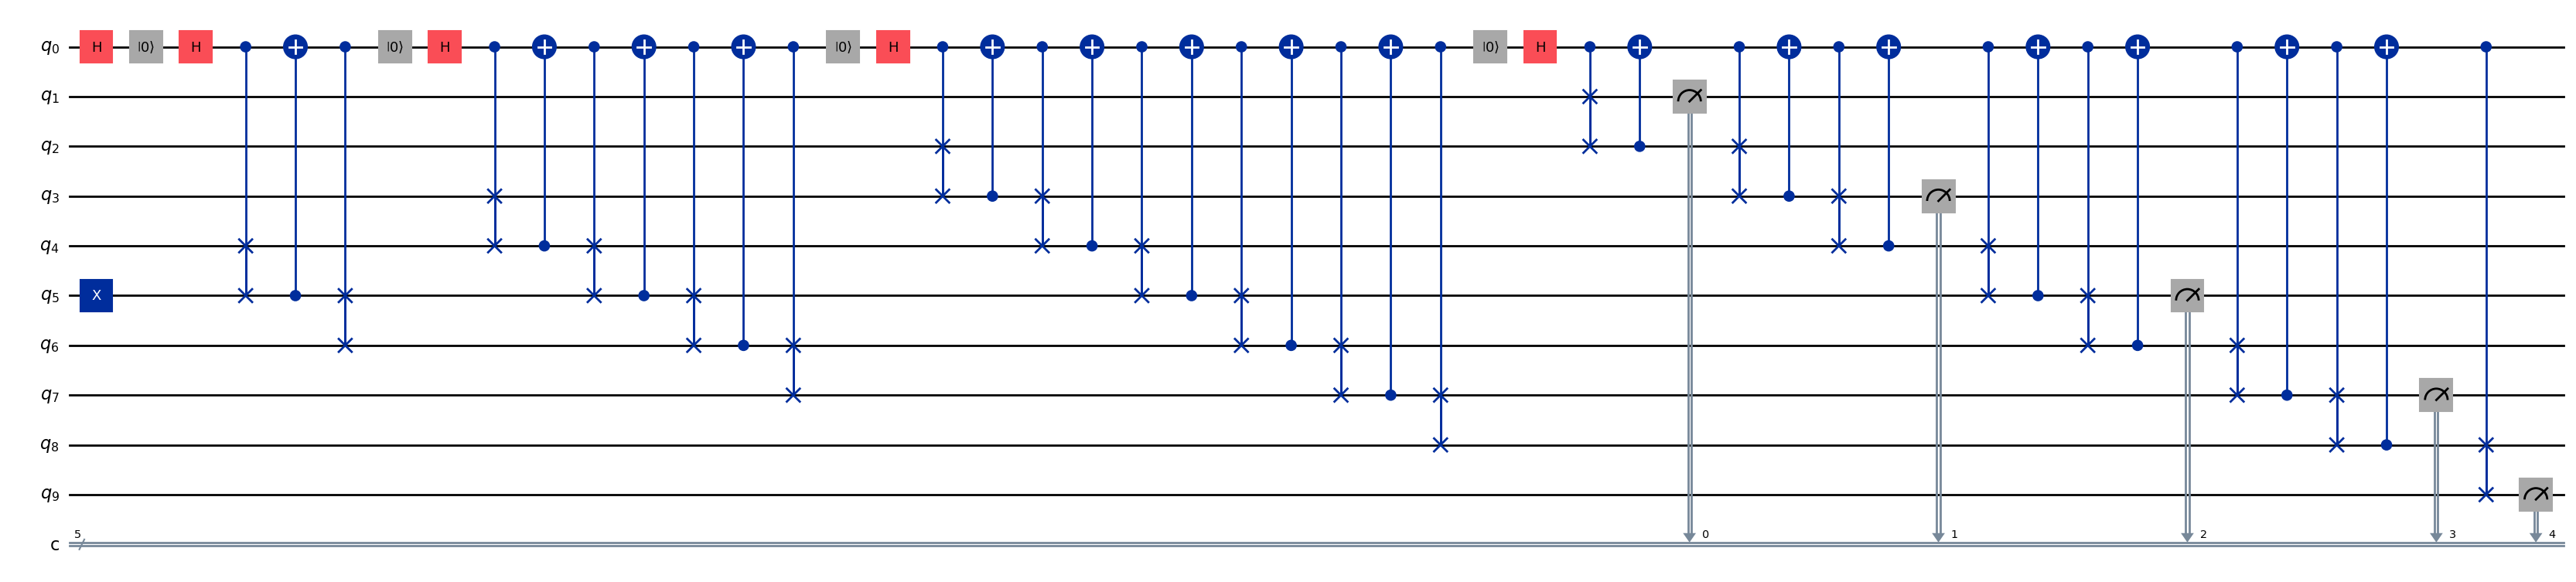

In [22]:
qc = create_qgb_circuit(4) # Creating 4-level circuit
qc.draw('mpl', fold = -1)

#### **Performing simulations**

Raw Counts: {'00100': 7510, '01000': 5030, '10000': 1254, '00010': 4934, '00001': 1272}


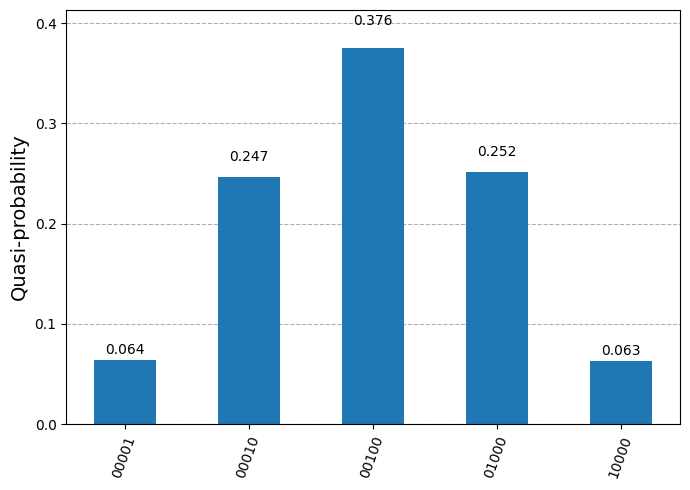

In [23]:
# Assume qc is your QGB circuit (e.g., level=4)
# Step 1: Simulate using Sampler and AerSimulator
backend = AerSimulator()
pass_manager = generate_preset_pass_manager(backend=backend, optimization_level=3)
qc_transpiled = pass_manager.run(qc)

sampler = Sampler(mode=backend)
job_result = sampler.run([qc_transpiled], shots=20000).result()

# Extract measurement counts from result
counts = job_result[0].data.c.get_counts()
# Note: The exact access pattern may vary with Qiskit version;
# sometimes it's .data.c or .data.meas — adjust accordingly based on your transpiled circuit.

print("Raw Counts:", counts)
plot_distribution(counts)

### **Post-processing**
In this post-processing demonstration, I ran the Quantum Galton Board circuit on a local simulator for 20,000 shots and recorded the bitstring outputs. Each valid bitstring pattern was mapped to an integer between 0 and 4 (e.g., `"00001" → 0`, `"00010" → 1`, etc.), allowing us to represent the quantum results numerically. The mapped dataset had a mean of 1.9977, a standard deviation of 1.001521, and a variance of 1.002995. To observe distribution scaling, we grouped the mapped outputs into blocks of 8 values, summing each block. This transformed the result range from {0, 1, 2, 3, 4} to {0, …, 32}, where 32 is the maximum possible sum (8 × 4). Finally, I plotted the frequency of these block sums alongside a fitted normal distribution curve, showing that the aggregated results follow a Gaussian shape. This technique demonstrates how quantum-generated discrete outputs can be rescaled and compared statistically, and it generalizes to any block size or maximum substitution value.

Detected bitstring orientation: reversed. We'll reverse each bitstring before mapping.
Total shots: 20000, Mapped shots: 20000, Unknown patterns: 0

Single-shot mapped statistics (values in {0,1,2,3,4}):
  Mean     = 2.012050
  Std dev  = 1.001426
  Variance = 1.002855

Per-position counts (0..4):
  pos 0: 1248
  pos 1: 4881
  pos 2: 7537
  pos 3: 5050
  pos 4: 1284

Number of full blocks of 8: 2500

Block-sum frequencies (0..32):
 sum  0: 0
 sum  1: 0
 sum  2: 0
 sum  3: 0
 sum  4: 0
 sum  5: 0
 sum  6: 2
 sum  7: 0
 sum  8: 5
 sum  9: 12
 sum 10: 33
 sum 11: 66
 sum 12: 133
 sum 13: 188
 sum 14: 277
 sum 15: 326
 sum 16: 362
 sum 17: 348
 sum 18: 258
 sum 19: 202
 sum 20: 144
 sum 21: 74
 sum 22: 34
 sum 23: 25
 sum 24: 8
 sum 25: 1
 sum 26: 1
 sum 27: 1
 sum 28: 0
 sum 29: 0
 sum 30: 0
 sum 31: 0
 sum 32: 0


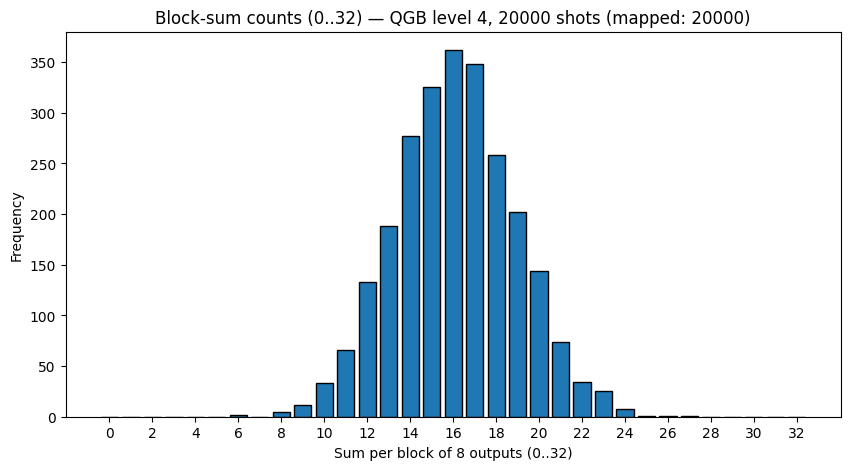

In [27]:
backend = AerSimulator()
pass_manager = generate_preset_pass_manager(backend=backend, optimization_level=1)  # use 1 for speed; change to 3 if you want heavy optimization
qc_transpiled = pass_manager.run(qc)

# Run with memory=True if possible (so we get per-shot bitstrings)
job = backend.run(qc_transpiled, shots=20000, memory=True)
result = job.result()

# --- robust extraction of per-shot bitstrings (as strings) ---
shot_bitstrings = None

# Try a few common ways to get the shot memory:
try:
    # new Aer result API
    shot_bitstrings = result.get_memory(0)   # usually returns list of bitstrings (strings)
except Exception:
    pass

if shot_bitstrings is None:
    # Sometimes memory is under results[0].data.memory
    try:
        shot_bitstrings = result.results[0].data.memory
    except Exception:
        pass

if shot_bitstrings is None:
    # Fallback: expand counts into a shot list (order will be arbitrary)
    try:
        counts = result.get_counts(0)
    except Exception:
        try:
            counts = result.results[0].data.counts
        except Exception:
            raise RuntimeError("Couldn't extract memory or counts from result. Check Qiskit/Aer version.")
    # expand counts -> list of strings
    shot_bitstrings = []
    for bitstr, c in counts.items():
        shot_bitstrings.extend([bitstr] * c)

# normalize bitstrings length (pad left with zeros if needed)
n_meas = qc.num_clbits  # expected 5 for level 4
shot_bitstrings = [s.rjust(n_meas, "0") for s in shot_bitstrings]

# --- detect endianness & mapping orientation ---
# target patterns (logical mapping): index -> pattern
target_patterns = {
    0: "00001",
    1: "00010",
    2: "00100",
    3: "01000",
    4: "10000"
}
pattern_set = set(target_patterns.values())

def count_matches(shot_list, reverse=False):
    total = 0
    for s in shot_list:
        key = s[::-1] if reverse else s
        if key in pattern_set:
            total += 1
    return total

matches_as_is = count_matches(shot_bitstrings, reverse=False)
matches_rev  = count_matches(shot_bitstrings, reverse=True)
reverse_flag = True if matches_rev >= matches_as_is else False
# choose orientation producing more matches
if reverse_flag:
    print("Detected bitstring orientation: reversed. We'll reverse each bitstring before mapping.")
else:
    print("Detected bitstring orientation: normal (no reverse).")

# build mapping: pattern -> int
pattern_to_int = {v: k for k, v in target_patterns.items()}

# --- map each shot to integer 0..4; collect unknowns separately ---
mapped_values = []
unknowns = Counter()
for s in shot_bitstrings:
    key = s[::-1] if reverse_flag else s
    if key in pattern_to_int:
        mapped_values.append(pattern_to_int[key])
    else:
        unknowns[key] += 1

mapped_values = np.array(mapped_values, dtype=int)
N_mapped = mapped_values.size
print(f"Total shots: {len(shot_bitstrings)}, Mapped shots: {N_mapped}, Unknown patterns: {sum(unknowns.values())}")

if sum(unknowns.values()) > 0:
    # show a few unexpected keys to help debugging
    print("Examples of unexpected measured bitstrings (will be ignored):")
    for idx, (k, v) in enumerate(unknowns.most_common(10)):
        print(f"  '{k}': {v} times")
    print("If many unknowns appear, check measurement order / circuit mapping.")

# --- statistics on single-shot mapped values ---
if N_mapped == 0:
    raise RuntimeError("No mapped shots available. Cannot compute statistics.")
mean_val = mapped_values.mean()
std_val = mapped_values.std(ddof=1) if N_mapped > 1 else float('nan')
var_val = mapped_values.var(ddof=1) if N_mapped > 1 else float('nan')

print("\nSingle-shot mapped statistics (values in {0,1,2,3,4}):")
print(f"  Mean     = {mean_val:.6f}")
print(f"  Std dev  = {std_val:.6f}")
print(f"  Variance = {var_val:.6f}")

# show per-position frequency
pos_counts = Counter(mapped_values)
print("\nPer-position counts (0..4):")
for p in range(5):
    print(f"  pos {p}: {pos_counts.get(p,0)}")

# --- BLOCKS of 8: print each block and its sum ---
if N_mapped < 8:
    raise RuntimeError("Not enough mapped shots to form a single block of 8.")

n_blocks = N_mapped // 8
trimmed = mapped_values[:n_blocks * 8]
blocks = trimmed.reshape(n_blocks, 8)
block_sums = blocks.sum(axis=1)

print(f"\nNumber of full blocks of 8: {n_blocks}")
# print("Printing every block (index: [values] -> sum):\n")
# for i, block in enumerate(blocks, start=1):
#     print(f"Block {i:5d}: {block.tolist()}  -> sum = {int(block_sums[i-1])}")

# --- frequency of sums 0..32 and plot ---

sum_counts = Counter(block_sums)
freqs = [sum_counts.get(s, 0) for s in range(33)]

print("\nBlock-sum frequencies (0..32):")
for s, f in enumerate(freqs):
    print(f" sum {s:2d}: {f}")

# plot histogram (33 bins: 0..32)
plt.figure(figsize=(10,5))
plt.bar(range(33), freqs, edgecolor='black')
plt.xlabel("Sum per block of 8 outputs (0..32)")
plt.ylabel("Frequency")
plt.title(f"Block-sum counts (0..32) — QGB level 4, {len(shot_bitstrings)} shots (mapped: {N_mapped})")
plt.xticks(range(0,33,2))
plt.show()

### **Match with Normal Distribution**
Let see how much our plot matches with Normal distribution


Block-sum frequencies (0..32):
 sum  0: 0
 sum  1: 0
 sum  2: 0
 sum  3: 0
 sum  4: 0
 sum  5: 0
 sum  6: 2
 sum  7: 0
 sum  8: 5
 sum  9: 12
 sum 10: 33
 sum 11: 66
 sum 12: 133
 sum 13: 188
 sum 14: 277
 sum 15: 326
 sum 16: 362
 sum 17: 348
 sum 18: 258
 sum 19: 202
 sum 20: 144
 sum 21: 74
 sum 22: 34
 sum 23: 25
 sum 24: 8
 sum 25: 1
 sum 26: 1
 sum 27: 1
 sum 28: 0
 sum 29: 0
 sum 30: 0
 sum 31: 0
 sum 32: 0


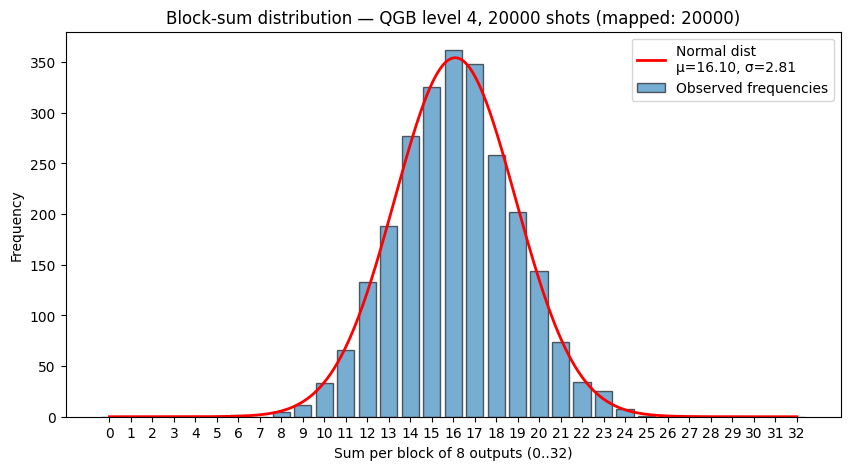

In [ ]:
sum_counts = Counter(block_sums)
freqs = [sum_counts.get(s, 0) for s in range(33)]

print("\nBlock-sum frequencies (0..32):")
for s, f in enumerate(freqs):
    print(f" sum {s:2d}: {f}")

# Prepare histogram and normal distribution curve
plt.figure(figsize=(10,5))

# Histogram (bar plot)
plt.bar(range(33), freqs, edgecolor='black', alpha=0.6, label="Observed frequencies")

# Normal distribution curve (scaled to match histogram total counts)
x_vals = np.linspace(0, 32, 1000)
mean_blocks = block_sums.mean()
std_blocks = block_sums.std(ddof=1)

# Normal PDF, scaled by (total blocks × bin width)
pdf_vals = norm.pdf(x_vals, loc=mean_blocks, scale=std_blocks)
pdf_scaled = pdf_vals * len(block_sums) * 1  # bin width = 1

plt.plot(x_vals, pdf_scaled, 'r-', linewidth=2, label=f"Normal dist\nμ={mean_blocks:.2f}, σ={std_blocks:.2f}")

plt.xlabel("Sum per block of 8 outputs (0..32)")
plt.ylabel("Frequency")
plt.title(f"Block-sum distribution — QGB level 4, {len(shot_bitstrings)} shots (mapped: {N_mapped})")
plt.xticks(range(0, 33, 1))
plt.legend()
plt.show()
